In [17]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import helpers
from src import dataset

In [2]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
data = dataset.load_excel(excel_file)
data = dataset.load_all_regions(data)

In [3]:
df_italy = data["italy"] # Arrivals to Italy
df_greek_island = data["greek_island"] # Arrivals to Greek Island
df_mainland_greece = data["mainland_greece"] # Arrivals to Mainland greece
df_fyrom = data["fyrom"] # Arrivals to fYRoM
df_serbia = data["serbia"] # Arrivals to Serbia
df_croatia = data["croatia"] # Arrivals to Croatia
df_hungry = data["hungry"] # Arrivals to Hungry
df_slovenia = data["slovenia"] # Arrivals to Slovenia
df_austria = data["austria"] # Arrivals to Austria

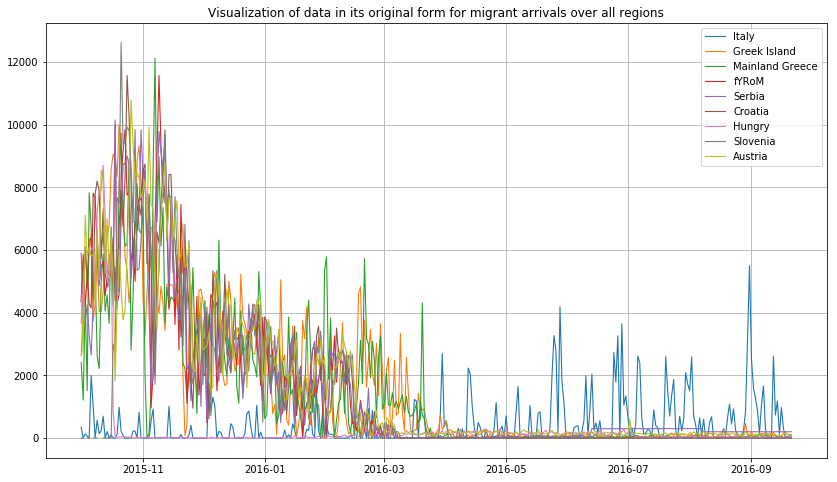

In [4]:
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals over all regions")
plt.grid(True)
plt.show()

In [133]:
df = df_austria # Seriies to test
column_name = df.columns[0]
print("Region %s will be used for the analysis" % column_name)

Region Arrivals to Austria will be used for the analysis


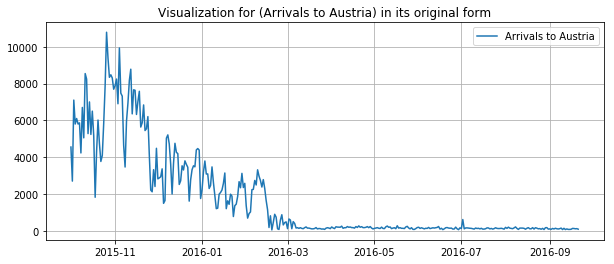

In [134]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [135]:
df.tail()

,Arrivals to Austria
Date,
2016-09-17,131
2016-09-18,127
2016-09-19,111
2016-09-20,119
2016-09-21,90


In [136]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [137]:
df_to_test.tail()

,Arrivals to Austria
Date,
2016-09-17,131
2016-09-18,127
2016-09-19,111
2016-09-20,119
2016-09-21,90


In [9]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [54]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [11]:
def sarima_configs(seasonal=None):
    """Generate all possible combinations of hyperparameters
    """
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [20]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            r2 = r2_score(series, prediction)
            result = (config, error, mae, r2)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [138]:
print(column_name)
results = grid_search(df_to_test)

Arrivals to Austria
([(0, 0, 0), (0, 0, 0, 365), 'n'], 2982.247120537663, 1733.781512605042, -0.5105469888409238)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 2982.247120537663, 1733.781512605042, -0.5105469888409238)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 2433.8393171732996, 1953.8574017842436, -0.006075999528053266)
([(0, 0, 0), (0, 0, 0, 365), 't'], 2933.7579798488846, 1861.95878896883, -0.46182556057682356)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 1495.6441038941964, 1171.5896661449528, 0.6200700678061959)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 1803.6905589506869, 992.3997983889192, 0.44745068130604515)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 1536.9512026576979, 1161.0000045265629, 0.5987942562440239)
([(0, 0, 1), (0, 0, 0, 365), 't'], 1780.0976667965788, 1066.9979606973661, 0.46181121249099966)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 1083.5281430475354, 798.7721159776376, 0.800598979991106)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 1435.3673193665797, 747.47760330893, 0.6500765145903291)
([(0, 0, 2), (0, 0, 0, 365), 'c

In [140]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]
r2 = results[0][3]
print(column_name)
print(best_combination, best_error, mae, r2)

Arrivals to Austria
[(2, 1, 2), (0, 0, 0, 365), 'c'] 782.5332850448124 406.16445158581934 0.8959953822248292


In [141]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=0, end=df_to_test.count()[0] - 1)

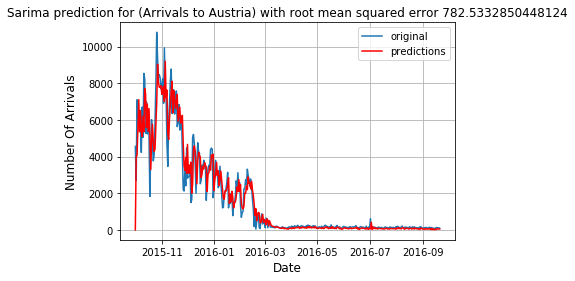

In [142]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(df_to_test, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()